# Advanced Serializion and Deserializion in Kafka

![](https://camo.githubusercontent.com/56166d361c3975dee750ecce16d605bbbf66516b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f352f35332f4170616368655f6b61666b615f776f7264747970652e737667)

# Preparing the field

In [9]:
from confluent_kafka.admin import AdminClient, NewTopic, NewPartitions

### Topics

In [10]:
topics = ["string_topic", "avro_topic"]
brokers = "kafka1:9092,kafka2:9093,"

### Preparing the field

In [11]:
a = AdminClient(conf = {'bootstrap.servers': brokers})

In [12]:
new_topics = [NewTopic(topic, num_partitions=2, replication_factor=1) for topic in topics]

In [13]:
fs = a.create_topics(new_topics)
for topic, f in fs.items():
    try:
        f.result()  # The result itself is None
        print("Topic {} created".format(topic))
    except Exception as e:
        print("Failed to create topic {}: {}".format(topic, e))

Topic string_topic created
Topic avro_topic created


## Producer

In [14]:
from confluent_kafka import SerializingProducer
from confluent_kafka.serialization import StringSerializer
import json
from uuid import uuid4

In [15]:
producer_conf = {
        'bootstrap.servers': brokers,
        'key.serializer': StringSerializer('utf_8'),
        'value.serializer': StringSerializer('utf_8')}

In [16]:
producer = SerializingProducer(producer_conf)

In [17]:
with open('./data.json') as f:
    data = json.load(f)
data

[{'picture': 'http://placehold.it/32x32',
  'age': 29,
  'name': 'Hull Gardner',
  'gender': 'male',
  'email': 'hullgardner@kneedles.com',
  'phone': '+372 (860) 490-3549',
  'address': '946 Victor Road, Adelino, Rhode Island, 3562',
  'about': 'Exercitation sint eu voluptate duis dolor ea occaecat officia. Consequat dolor et consectetur non adipisicing anim aliquip non mollit officia qui. Minim excepteur Lorem labore est officia ad voluptate. Consectetur elit aliqua reprehenderit cupidatat officia dolore sunt.\r\n'},
 {'picture': 'http://placehold.it/32x32',
  'age': 28,
  'name': 'Rice Gonzalez',
  'gender': 'male',
  'email': 'ricegonzalez@kneedles.com',
  'phone': '+372 (956) 471-3802',
  'address': '251 Church Avenue, Weedville, Michigan, 9128',
  'about': 'Sunt Lorem dolore cillum duis ipsum sit officia dolor elit. Cupidatat magna magna occaecat id incididunt et est enim incididunt ex exercitation est. Ea dolor ad enim duis ea.\r\n'},
 {'picture': 'http://placehold.it/32x32',
  

In [18]:
for m in data:
    print(m)
    producer.produce(topic=topics[0],key=str(uuid4()),value=str(m))
    producer.poll(0)

{'picture': 'http://placehold.it/32x32', 'age': 29, 'name': 'Hull Gardner', 'gender': 'male', 'email': 'hullgardner@kneedles.com', 'phone': '+372 (860) 490-3549', 'address': '946 Victor Road, Adelino, Rhode Island, 3562', 'about': 'Exercitation sint eu voluptate duis dolor ea occaecat officia. Consequat dolor et consectetur non adipisicing anim aliquip non mollit officia qui. Minim excepteur Lorem labore est officia ad voluptate. Consectetur elit aliqua reprehenderit cupidatat officia dolore sunt.\r\n'}
{'picture': 'http://placehold.it/32x32', 'age': 28, 'name': 'Rice Gonzalez', 'gender': 'male', 'email': 'ricegonzalez@kneedles.com', 'phone': '+372 (956) 471-3802', 'address': '251 Church Avenue, Weedville, Michigan, 9128', 'about': 'Sunt Lorem dolore cillum duis ipsum sit officia dolor elit. Cupidatat magna magna occaecat id incididunt et est enim incididunt ex exercitation est. Ea dolor ad enim duis ea.\r\n'}
{'picture': 'http://placehold.it/32x32', 'age': 30, 'name': 'Augusta Yates',

In [19]:
producer.flush()

0

## Consumer

In [20]:
from confluent_kafka import DeserializingConsumer
from confluent_kafka.serialization import StringDeserializer

In [21]:
string_deserializer = StringDeserializer('utf_8')

In [22]:
consumer_conf = {
    'bootstrap.servers': brokers,
    'key.deserializer': string_deserializer,
    'value.deserializer': string_deserializer,
    'group.id': str(uuid4()),
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'}

In [23]:
consumer = DeserializingConsumer(consumer_conf)
consumer.subscribe([topics[0]])
topics[0]

'string_topic'

In [24]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            print("{} [{}] at offset  {} with key  {}:  {}".format(msg.topic(), msg.partition(), msg.offset(), str(msg.key()), str(msg.value())))
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    consumer.close()

string_topic [1] at offset  0 with key  3dffd32c-4377-40d5-bbaa-958336c2dd60:  {'picture': 'http://placehold.it/32x32', 'age': 29, 'name': 'Hull Gardner', 'gender': 'male', 'email': 'hullgardner@kneedles.com', 'phone': '+372 (860) 490-3549', 'address': '946 Victor Road, Adelino, Rhode Island, 3562', 'about': 'Exercitation sint eu voluptate duis dolor ea occaecat officia. Consequat dolor et consectetur non adipisicing anim aliquip non mollit officia qui. Minim excepteur Lorem labore est officia ad voluptate. Consectetur elit aliqua reprehenderit cupidatat officia dolore sunt.\r\n'}
string_topic [1] at offset  1 with key  37618704-4593-47dc-8bee-2e720d473558:  {'picture': 'http://placehold.it/32x32', 'age': 28, 'name': 'Rice Gonzalez', 'gender': 'male', 'email': 'ricegonzalez@kneedles.com', 'phone': '+372 (956) 471-3802', 'address': '251 Church Avenue, Weedville, Michigan, 9128', 'about': 'Sunt Lorem dolore cillum duis ipsum sit officia dolor elit. Cupidatat magna magna occaecat id incid

NameError: name 'sys' is not defined

# Apache Avro

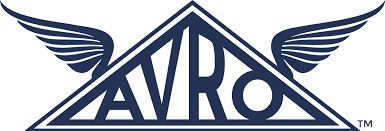

Avro is a binary encoding format that uses a schema to specify the structure of the data being encoded.

Avro's encoding consists only of values concatenated together, and the there is nothing to identify fields or their datatypes in the byte sequence.

```json
{
"namespace": "kafka.exercise.avro",
 "type": "record",
 "name": "Observation",
 "fields": [
     {"name": "id", "type": "long", "doc" : "The observation id"},
     {"name": "value", "type": "double", "doc" : "The actual measurement from the sensor"},
     {"name": "measurement", "type": "string", "doc" : "The measurement type, e.g., temperature"},
     {"name": "timestamp", "type": "long", "doc" : "The measurement timestamp"}
 ]
}
```

### Schema Registry

Schema registry provides centralized management of schemas
* Stores a versioned history of all schemas
* Provides a RESTful interface for storing and retrieving Avro schemas
* Checks schemas and throws an exception if data does not conform to the schema – Allows evolution of schemas according to the configured compatibility setting

![](https://www.marcusvieira.tech/wp-content/uploads/2019/06/screenshot-2019-06-03-at-00.40.39.png)

In [25]:
from confluent_kafka.schema_registry import SchemaRegistryClient

In [26]:
schema_registry_conf = {'url': "http://schema-registry:8081"}
schema_registry_client = SchemaRegistryClient(schema_registry_conf)

schema_registry_client.get_subjects()

[]

In [27]:
from confluent_kafka.schema_registry.avro import AvroSerializer
import random, time
from uuid import uuid4

In [28]:
value_schema = open("observation.avsc").read()
value_schema

'{\n"namespace": "kafka.exercise.avro",\n "type": "record",\n "name": "Observation",\n "fields": [\n     {"name": "id", "type": "long", "doc" : "The observation id"},\n     {"name": "value", "type": "double", "doc" : "The actual measurement from the sensor"},\n     {"name": "measurement", "type": "string", "doc" : "The measurement type, e.g., temperature"},\n     {"name": "timestamp", "type": "long", "doc" : "The measurement timestamp"}\n ]\n}'

## Writing to Topic "avro_topic"

In [29]:
avro_serializer = AvroSerializer(value_schema, schema_registry_client)

producer_conf = {'bootstrap.servers': brokers,
                 'key.serializer': StringSerializer('utf_8'),
                 'value.serializer': avro_serializer,
                 'partitioner': 'murmur2_random',
}

producer = SerializingProducer(producer_conf)

In [30]:
rooms = ["room1", "room2", "room3", "room4"]

In [31]:
for i in range(1,10):
    value = {"id": i, 
               "value": random.uniform(0,50), 
               "measurement":"temperature", 
               "timestamp": round(time.time()*1000)}
    key = rooms[ random.randint(0,3)]
    print(key + " " + str(value))
    producer.poll(0)
    producer.produce(topic=topics[1], value=value, key=key)
    producer.flush(1)


room3 {'id': 1, 'value': 5.895162701291262, 'measurement': 'temperature', 'timestamp': 1603091448377}
room4 {'id': 2, 'value': 18.708220577714112, 'measurement': 'temperature', 'timestamp': 1603091449204}
room4 {'id': 3, 'value': 46.32359549052976, 'measurement': 'temperature', 'timestamp': 1603091449215}
room4 {'id': 4, 'value': 11.127091928843685, 'measurement': 'temperature', 'timestamp': 1603091449222}
room4 {'id': 5, 'value': 8.508675124254978, 'measurement': 'temperature', 'timestamp': 1603091449229}
room3 {'id': 6, 'value': 1.0253650644991064, 'measurement': 'temperature', 'timestamp': 1603091449236}
room2 {'id': 7, 'value': 1.9134003613156758, 'measurement': 'temperature', 'timestamp': 1603091449243}
room3 {'id': 8, 'value': 37.04788909612917, 'measurement': 'temperature', 'timestamp': 1603091449250}
room2 {'id': 9, 'value': 46.66300192928095, 'measurement': 'temperature', 'timestamp': 1603091449257}


In [32]:
schema_registry_client.get_subjects()

['avro_topic-value']

Once the producer writes, it communicates with the Schema Registry, registering the schema of the message.

In [36]:
from confluent_kafka import DeserializingConsumer
from confluent_kafka.schema_registry.avro import AvroDeserializer

In [37]:
avro_deserializer = AvroDeserializer(value_schema,schema_registry_client)

string_deserializer = StringDeserializer('utf_8')

In [38]:
consumer_conf = {'bootstrap.servers': brokers,
                     'key.deserializer': string_deserializer,
                     'value.deserializer': avro_deserializer,
                     'group.id': str(uuid4()),
                     'auto.offset.reset': "earliest"}

consumer = DeserializingConsumer(consumer_conf)
consumer.subscribe([topics[1]])

In [39]:
while True:
    try:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        m = msg.value()
        if m is not None:
            print(m)
    except KeyboardInterrupt:
        break
        consumer.close()

{'id': 1, 'value': 5.895162701291262, 'measurement': 'temperature', 'timestamp': 1603091448377}
{'id': 6, 'value': 1.0253650644991064, 'measurement': 'temperature', 'timestamp': 1603091449236}
{'id': 7, 'value': 1.9134003613156758, 'measurement': 'temperature', 'timestamp': 1603091449243}
{'id': 8, 'value': 37.04788909612917, 'measurement': 'temperature', 'timestamp': 1603091449250}
{'id': 9, 'value': 46.66300192928095, 'measurement': 'temperature', 'timestamp': 1603091449257}
{'id': 2, 'value': 18.708220577714112, 'measurement': 'temperature', 'timestamp': 1603091449204}
{'id': 3, 'value': 46.32359549052976, 'measurement': 'temperature', 'timestamp': 1603091449215}
{'id': 4, 'value': 11.127091928843685, 'measurement': 'temperature', 'timestamp': 1603091449222}
{'id': 5, 'value': 8.508675124254978, 'measurement': 'temperature', 'timestamp': 1603091449229}


#### What if we do not know the schema?

We can't see this in python because of a bug of the Avro library. However, we can observe it from [Java](link to the other repo class)

[Github Rebo Java Code](https://github.com/riccardotommasini/kafka-training/tree/dataeng)